In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from tqdm import tqdm
import cv2
import skimage
from skimage.transform import resize



E:\anacondaconda3\envs\signLan\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
E:\anacondaconda3\envs\signLan\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
E:\anacondaconda3\envs\signLan\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [4]:
import numpy as np
from PIL import Image
import os
from tqdm import tqdm

imageSize = 64
target_dims = (imageSize, imageSize, 3)
num_classes = 28
train_len = 39200
# train_dir = './dataset_raw_cropped/asl_alphabet_train/'
train_dir = 'E:/ML_ASL_try/new_cropped_images/'
coord_file = 'E:/ML_ASL_try/new_landmarks_data/hand_landmarks.npz' 


label_map = {
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9,
    'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18,
    'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'space': 27
}

# loading both coor & img
def get_data(folder, coord_file):
    # load coordinate data
    coord_data = np.load(coord_file)
    
    X_img = np.empty((train_len, imageSize, imageSize, 3), dtype=np.float32)
    X_coord = np.empty((train_len, 42), dtype=np.float32)  # 42 coordinates from MediaPipe (21 landmarks with x,y coor)
    y = np.empty((train_len,), dtype=np.int)
    
    cnt = 0
    
    for folderName in tqdm(os.listdir(folder)):
        if folderName.startswith('.'):
            continue
        
        label = label_map.get(folderName, 28)
        folder_path = os.path.join(folder, folderName)
        
        for image_filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, image_filename)
            
            try:
                # load img
                with Image.open(img_path) as img:
                    img_resized = img.resize((imageSize, imageSize))
                    img_arr = np.array(img_resized)
                    
                    # get corresponding coordinates, the coord_data keys match the img path (the keys in .npz file is the img path)
                    coord_key = f"{folderName}/{image_filename}"
                    if coord_key in coord_data:
                        coords = coord_data[coord_key]
                        
                        X_img[cnt] = img_arr
                        X_coord[cnt] = coords
                        y[cnt] = label
                        cnt += 1
                        
                        if cnt >= train_len:
                            return X_img, X_coord, y
                    
            except Exception as e:
                print(f"Error occurred for {img_path}: {e}")
                
    return X_img[:cnt], X_coord[:cnt], y[:cnt]

def prepare_data(image_folder, coord_file):
    # load both image and coordinate data
    X_img, X_coord, y = get_data(image_folder, coord_file)
    
    X_img = X_img / 255.0  # normalize img
    
    
    print(f"Loaded {len(X_img)} samples")
    print(f"Image data shape: {X_img.shape}")
    print(f"Coordinate data shape: {X_coord.shape}")
    print(f"Label shape: {y.shape}")
    
    return X_img, X_coord, y



In [5]:
X_img, X_coord, y = prepare_data(train_dir, coord_file)

 96%|███████████████████████████████████████████████████████████████████████████████   | 27/28 [09:13<00:20, 20.52s/it]


Loaded 39200 samples
Image data shape: (39200, 64, 64, 3)
Coordinate data shape: (39200, 42)
Label shape: (39200,)


In [17]:
from sklearn.model_selection import train_test_split

X_train_img, X_test_img, X_train_coord, X_test_coord, y_train, y_test = train_test_split(
    X_img, X_coord, y,
    test_size=0.3,
    random_state=42,
    stratify=y,
    shuffle=True
)
print(f"Training set size: {len(X_train_img)}")
print(f"Test set size: {len(X_test_img)}")

Training set size: 27440
Test set size: 11760


In [29]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=28)
y_test = to_categorical(y_test, num_classes=28)

In [31]:
# multi-modal VGG

In [46]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def custom_generator(X_img, X_coord, y, batch_size=32):
   while True:
       idx = np.random.randint(0, X_img.shape[0], batch_size)
       yield [X_img[idx], X_coord[idx]], y[idx]

img_input = Input(shape=(64, 64, 3), name='image_input')
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=img_input)

for layer in base_model.layers:
   layer.trainable = False

# FC layer
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)

# coor branch
coord_input = Input(shape=(42,), name='coord_input')
y = Dense(128, activation='relu')(coord_input)
# combine 2 branches
combined = concatenate([x, y])
z = Dense(512, activation='relu')(combined)
predictions = Dense(28, activation='softmax')(z)

model = Model(inputs=[img_input, coord_input], outputs=predictions)

model.summary()






Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 64, 64, 64)   1792        image_input[0][0]                
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 64, 64, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 32, 32, 64)   0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [47]:
# creating generators
train_gen = custom_generator(X_train_img, X_train_coord, y_cat_train, batch_size=128)
val_gen = custom_generator(X_test_img, X_test_coord, y_cat_test, batch_size=128)

callbacks = [
   EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
   ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max'),
   ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]

model.compile(
   loss='categorical_crossentropy',
   optimizer=Adam(learning_rate=0.0001),
   metrics=['accuracy']
)

history = model.fit(
    (X_train_img, X_train_coord),
    y_train,
    batch_size=128,
    epochs=10,
    validation_data=((X_test_img, X_test_coord), y_test),
    callbacks=callbacks,
    verbose=1,
    shuffle=True
)


Epoch 1/10
215/215 [==============================] - 68s 317ms/step - loss: 1.4053 - accuracy: 0.7622 - val_loss: 0.4228 - val_accuracy: 0.9361 - lr: 1.0000e-04
Epoch 2/10
215/215 [==============================] - 71s 332ms/step - loss: 0.2658 - accuracy: 0.9605 - val_loss: 0.1800 - val_accuracy: 0.9734 - lr: 1.0000e-04
Epoch 3/10
215/215 [==============================] - 83s 387ms/step - loss: 0.1324 - accuracy: 0.9815 - val_loss: 0.1057 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 4/10
215/215 [==============================] - 83s 388ms/step - loss: 0.0824 - accuracy: 0.9890 - val_loss: 0.0746 - val_accuracy: 0.9875 - lr: 1.0000e-04
Epoch 5/10
215/215 [==============================] - 76s 354ms/step - loss: 0.0575 - accuracy: 0.9929 - val_loss: 0.0568 - val_accuracy: 0.9909 - lr: 1.0000e-04
Epoch 6/10
215/215 [==============================] - 90s 418ms/step - loss: 0.0423 - accuracy: 0.9949 - val_loss: 0.0451 - val_accuracy: 0.9923 - lr: 1.0000e-04
Epoch 7/10
215/215 [========

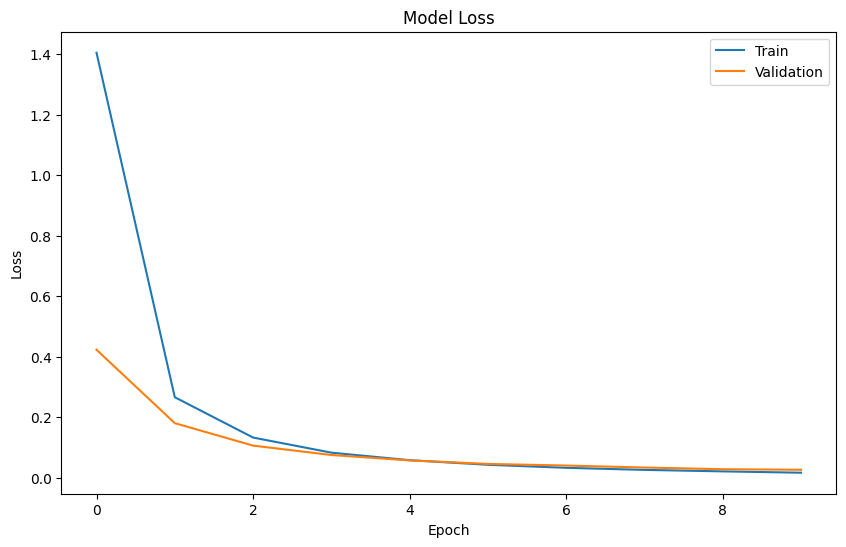

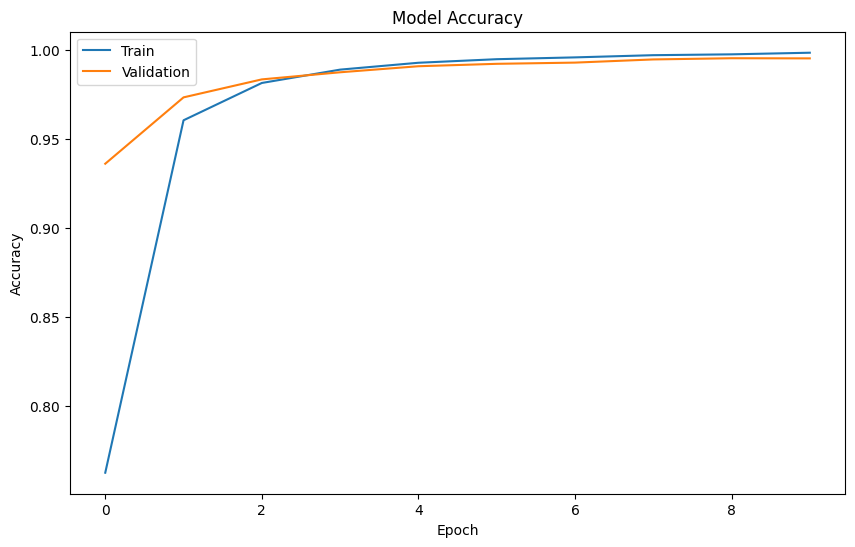

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions_prob = model.predict([X_test_img, X_test_coord])
predictions = np.argmax(predictions_prob, axis=1)

# acc & loss curves
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()



In [59]:
print("Classification Report:")
print(classification_report(y_test_classes, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       420
           1       1.00      1.00      1.00       420
           2       1.00      1.00      1.00       420
           3       1.00      1.00      1.00       420
           4       1.00      1.00      1.00       420
           5       1.00      1.00      1.00       420
           6       1.00      1.00      1.00       420
           7       1.00      1.00      1.00       420
           8       1.00      0.99      0.99       420
           9       1.00      1.00      1.00       420
          10       1.00      1.00      1.00       420
          11       1.00      1.00      1.00       420
          12       0.96      0.99      0.97       420
          13       0.99      0.97      0.98       420
          14       1.00      1.00      1.00       420
          15       1.00      1.00      1.00       420
          16       1.00      1.00      1.00       420
    

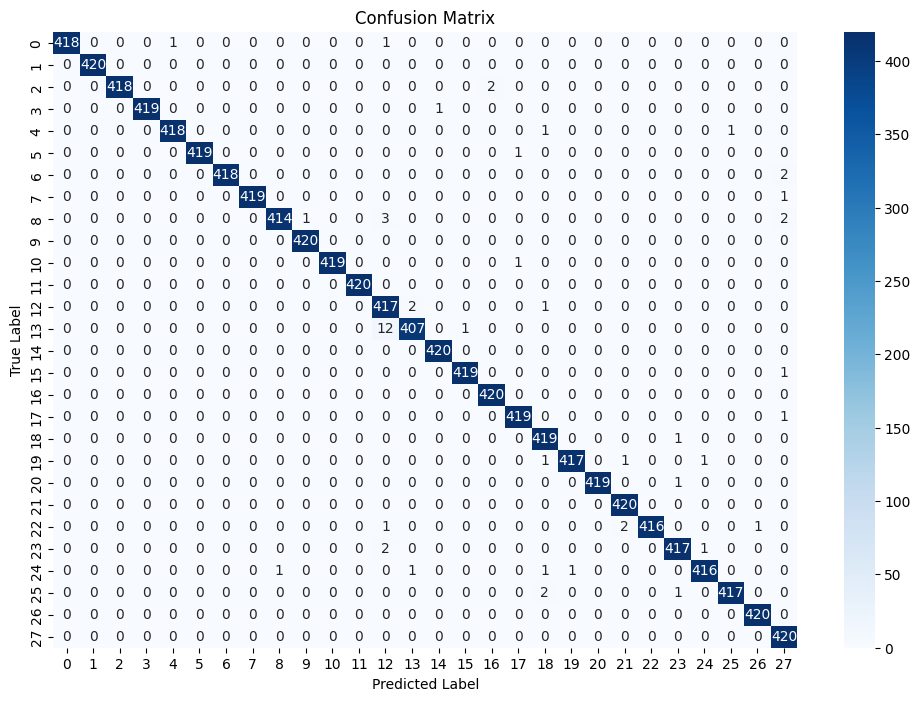

In [65]:
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test_classes, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()